# Working with Neural networks

In [36]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [37]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## convert MNIST dataset image to tensors

In [38]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

In [39]:
train_data, test_data, type(test_data)

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ../data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ../data
     Split: Test
     StandardTransform
 Transform: ToTensor(),
 torchvision.datasets.mnist.MNIST)

In [40]:
image, label = train_data[2]
image.shape
# note only 1 channel indicates greyscale image
# 28, 28 is the size of the original binary array

torch.Size([1, 28, 28])

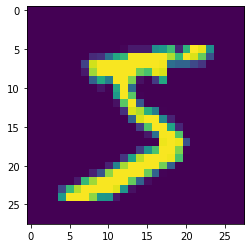

In [41]:
plt.imshow(train_data[0][0].reshape((28,28)))

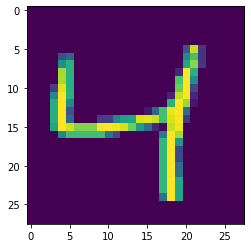

In [42]:
# we can drop the uninformative first channel
plt.imshow(image.reshape((28, 28)))

In [61]:
# we will load data in batches, but randomly
torch.manual_seed(101)

# 100 images per batch, fetched randomly from dataset
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

# visualize what these image batches look like


In [44]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

In [45]:
for images, labels in train_loader:
    break

tensor([7, 2, 3, 5, 8, 5, 3, 6, 9, 9, 1, 3])

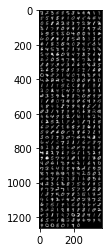

In [46]:
# print first 12 images
im = make_grid(images, nrow=12)
# currently im contains color-width-height channel format
plt.figure(figsize=(10, 4))
# plt imshow expects width-height-color channel
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
labels[:12]
# (1,2,0) is the index of the WHC as expected

# Fully connected layers
every neuron of one layer is connected to every neuron of other

in MLP using fully connected layer, matrix multiplication is done <br>
between the connected layers so we need to have 1D array only.

In [47]:
# defining our model

class MultiLayerPerceptron(nn.Module):
    # input is 1D input layer [28*28] needed for fully connected layers
    # output is 10 neuron layer [0-9 labels]
    # hidden layers have 120 and 84 resp. (arbit)
    def __init__(self, in_sz=784, out_sz=10, layers=[120, 84]):
        super().__init__()
        # fully connected layers between input and hidden and output
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)
    
    def forward(self, X):
        # this function passes the input features forward
        # X is our data feature
        # F contains our relu (rectified linear unit)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        # multi class classification needs single dimension output
        return F.log_softmax(X, dim=1)

In [48]:
torch.manual_seed(101)
model = MultiLayerPerceptron()
model

MultiLayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [49]:
# we can visualize all connections from input array 
# begins with 784 neurons connecting to 120 (=94080) and so on
for param in model.parameters():
    print(param.numel())
# In total 105214 parameters being controlled by this ANN
# each with its own biases but in CNN, this reduces

94080
120
10080
84
840
10


In [50]:
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [55]:
# We want to convert the shape of the images 
images.shape # (100,1,28,28) -> (100, 784)
# -1 considers rest of the axes together in view
images.view(100, -1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [64]:
import time
start = time.time()

# training
epochs = 10

# track to visualize later
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(10):
    train_corr = 0
    test_corr = 0

    # get image and its label from train_loader
    for batch, (x_train, y_train) in enumerate(train_loader):
        # avoid dividing by 0
        batch=batch+1
        # flatten out the image for model using view
        y_pred = model(x_train.view(100, -1))
        loss = criterion(y_pred, y_train)

        # get the number that had the highest probablity from the 
        # 10 neurons at the end, probs are along the `, 1` axis
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted==y_train).sum()
        train_corr +=batch_corr

        # back propagate the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%200==0:
            acc = train_corr.item()*100/(100*batch)
            print(f'epoch {i}, batch {batch}, loss {loss.item()}, accuracy {acc}')
    train_losses.append(loss)
    train_correct.append(train_corr)

    # see how validation data is getting affected with every epoch
    with torch.no_grad():
        for b, (x_test, y_test) in enumerate(test_loader):
            # test data had 500 batch size 
            y_val = model(x_test.view(500, -1))
            predicted=torch.max(y_val, 1)[1]
            test_corr+=(predicted==y_test).sum()
        
        loss=criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(test_corr)


print(f'Total time: {(time.time() - start)/60:.2f}min')

epoch 0, batch 200, loss 0.2163444310426712, accuracy 94.945
epoch 0, batch 400, loss 0.10329414159059525, accuracy 95.3025
epoch 0, batch 600, loss 0.1625654399394989, accuracy 95.50833333333334
epoch 1, batch 200, loss 0.11501789838075638, accuracy 96.7
epoch 1, batch 400, loss 0.07232130318880081, accuracy 96.7575
epoch 1, batch 600, loss 0.12100724875926971, accuracy 96.86166666666666
epoch 2, batch 200, loss 0.039393939077854156, accuracy 97.44
epoch 2, batch 400, loss 0.0623573437333107, accuracy 97.57
epoch 2, batch 600, loss 0.09507627785205841, accuracy 97.54833333333333
epoch 3, batch 200, loss 0.06626773625612259, accuracy 98.17
epoch 3, batch 400, loss 0.08200079947710037, accuracy 98.11
epoch 3, batch 600, loss 0.012399141676723957, accuracy 98.04666666666667
epoch 4, batch 200, loss 0.02036498486995697, accuracy 98.62
epoch 4, batch 400, loss 0.061476241797208786, accuracy 98.415
epoch 4, batch 600, loss 0.042572781443595886, accuracy 98.34166666666667
epoch 5, batch 200,

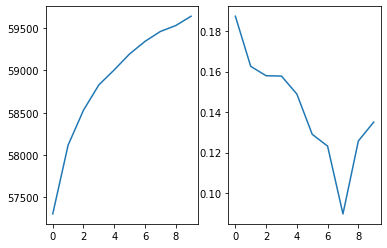

In [76]:
# plot our loss and correctness
fig, (ax1,ax2)=plt.subplots(1,2)
ax1.plot(train_correct)
ax2.plot(test_losses)

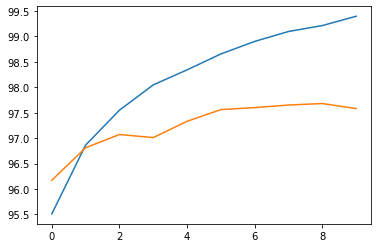

In [82]:
# plot accuracies
train_acc = [x/600 for x in train_correct] #600 is batch size
test_acc = [x/100 for x in test_correct] #100 is batch size for test
fig, ax1=plt.subplots(1,1)
ax1.plot(train_acc)
ax1.plot(test_acc)

# we want to see that crossing point, if it doesn't  occur we can run for more epochs

In [83]:
# confusion matrix (representing number of detections)
confusion_matrix(predicted.view(-1), y_test.view(-1))

# ideally we want to see highest diagonal values (x->predicted, y->actual 0-9)
# rest of the matrix shows how many false positives we got for the actual nums
# not supposed to be a mirror
# we can get accuracy and precision etc from this matrix

array([[  49,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,   60,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,   44,    0,    1,    0,    0,    0,    0,    0],
       [   0,    0,    1,   51,    0,    0,    1,    0,    0,    0],
       [   0,    0,    0,    0,   49,    0,    0,    0,    0,    1],
       [   0,    0,    1,    1,    0,   41,    4,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,   44,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,   59,    0,    1],
       [   1,    0,    2,    0,    0,    0,    0,    0,   48,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,   41]],
      dtype=int64)

# to see the false positives

In [85]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i]!=y_test[i]:
        misses=np.append(misses, i).astype('int64')
print(f'We missed {len(misses)}')

We missed 14


In [87]:
misses

array([  87,  134,  136,  179,  192,  198,  200,  226,  236,  245,  282,
        293,  339,  404], dtype=int64)

Index of missed nums: tensor([ 87, 134, 136, 179, 192, 198])
Label of missed nums: tensor([9, 0, 3, 6, 9, 6])
False values of nums: [   4    8    5    3    7    5]
Index of missed nums: tensor([226, 236, 245, 282, 293, 339])
Label of missed nums: tensor([2, 6, 4, 6, 6, 2])
False values of nums: [   5    5    2    5    5    3]


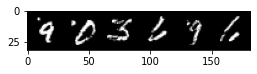

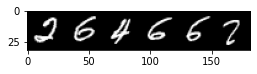

In [105]:
i=-1
for row in [6, 13]:
    missed_batch = torch.Tensor(misses[i+1: row]).to(torch.int64)
    print(f'Index of missed nums: {missed_batch}')
    print(f'Label of missed nums: {y_test.index_select(0, missed_batch)}')
    print(f'False values of nums: {predicted.index_select(0, missed_batch).numpy()}')
    i=row

    images = x_test.index_select(0, missed_batch)
    im=make_grid(images,nrow=7)
    plt.figure(figsize=(4, 10))
    plt.imshow(np.transpose(im.numpy(), (1,2,0)))